# ノード埋め込みによるCareerVillageナレッジグラフ分析

# 1. 導入

## a.)ナレッジグラフとは


これは、同じグラフで複数のタイプのエンティティ（ノード）と関係（エッジ）を表すネットワークです。ネットワークの各リンクは、（エンティティ、関係、値）3つを表します。たとえば、以下の小さなナレッジグラフの例をいくつか挙げます。


- エッフェル塔**（エンティティ）**はパリの**（値）**にあります**（関係）**
- Paris**（エンティティ）**は都市**（値）**のインスタンスです**(関係)**
- アリス**（エンティティ）**は人**（値）**のインスタンスです**(関係)**


![Example knowledge graph](https://geomarketing.com/wp-content/uploads/2017/11/Amazon-Neptune-Knowledge-Graph.jpg)

CareerVillageデータセットには、いくつかの異なるエンティティ（個人、グループ、学校、場所など）が含まれています。したがって、このデータを分析する1つの可能なアプローチは、できるだけ多くの関係を表す大きな知識グラフを作成することです。

## b.) ノード埋め込みとは

埋め込み、特に単語の表現（例：Word2Vec）は、今日のホットな研究トピックです。ノード埋め込みアルゴリズム（node2vec、Line、DeepWalkなど）の背後にある基本的な考え方は、特定の頂点から発生するノードシーケンスを生成し、Word2Vecにフィードする場合（テキストの文のように）、ネットワークのノードを低次元のベクトル空間。通常、これらのメソッドは、グラフの各頂点のグローバル/ローカルの役割を維持するための基準に合わせて最適化されています。


![Example node embeding](https://www.sentiance.com/wp-content/uploads/2018/01/deepwalk1-2.png)

## c.) My work

本研究では、[node2vec](https://cs.stanford.edu/people/jure/pubs/node2vec-kdd16.pdf)アルゴリズムを用いて、データから抽出したナレッジグラフに基づいて、キャリアビレッジのユーザーのための低次元表現を生成しています。最終的な目標は、利用可能なネットワーク構造を利用して、興味深いユーザーグループ／クラスタ（例：人気のある専門家、満足度の高い学生など）を発見することです。

> # 2. Load data

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter

In [2]:
files = os.listdir("./data-science-for-good-careervillage")
files

['groups.csv',
 'professionals.csv',
 'tag_questions.csv',
 'emails.csv',
 'answers.csv',
 'group_memberships.csv',
 'tag_users.csv',
 'matches.csv',
 'answer_scores.csv',
 'tags.csv',
 'comments.csv',
 'questions.csv',
 'school_memberships.csv',
 'question_scores.csv',
 'students.csv']

In [3]:
data_parts = {}
for file_name in files:
    file_id = file_name.split(".")[0]
    data_parts[file_id] = pd.read_csv("./data-science-for-good-careervillage/" + file_name)
    print(file_id)
    print(data_parts[file_id].shape)

groups
(49, 2)
professionals
(28152, 5)
tag_questions
(76553, 2)
emails
(1850101, 4)
answers
(51123, 5)
group_memberships
(1038, 2)
tag_users
(136663, 2)
matches
(4316275, 2)
answer_scores
(51138, 2)
tags
(16269, 2)
comments
(14966, 5)
questions
(23931, 5)
school_memberships
(5638, 2)
question_scores
(23928, 2)
students
(30971, 3)


# 3. キャリアビレッジのデータからナレッジグラフを構築

In [4]:
def add_nodes(G, df, col, type_name):
    """DataFrame 'df' の 'col' カラムから G にエンティティを追加します。新しいノードは 'type_name' ラベルでアノテーションされます。"""
    nodes = list(df[~df[col].isnull()][col].unique())
    G.add_nodes_from([(n,dict(type=type_name)) for n in nodes])
    print("Nodes (%s,%s) were added" % (col, type_name))
    
def add_links(G, df, col1, col2, type_name):
    """'df' DataFrameからGへのリンクを追加します。新しいエッジは 'type_name' ラベルでアノテーションされます。"""
    df_tmp = df[(~df[col1].isnull()) & (~df[col2].isnull())]
    links = list(zip(df_tmp[col1],df_tmp[col2]))
    G.add_edges_from([(src, trg, dict(type=type_name)) for src, trg in links])
    print("Edges (%s->%s,%s) were added" % (col1, col2, type_name))

In [5]:
G = nx.DiGraph()

## i.) Nodes

知識グラフの頂点は、次の実体から構成されている。]
- answers
- questions
- comments
- students
- professionals
- industries
- schools
- tags
- user groups
- group types

In [6]:
add_nodes(G, data_parts["answers"], "answers_id", "answer")
add_nodes(G, data_parts["comments"], "comments_id", "comment")
add_nodes(G, data_parts["groups"], "groups_id", "group")
add_nodes(G, data_parts["groups"], "groups_group_type", "group_type")
add_nodes(G, data_parts["professionals"], "professionals_id", "professional")
add_nodes(G, data_parts["professionals"], "professionals_industry", "industry")
add_nodes(G, data_parts["questions"], "questions_id", "question")
add_nodes(G, data_parts["school_memberships"], "school_memberships_school_id", "school")
add_nodes(G, data_parts["students"], "students_id", "student")
add_nodes(G, data_parts["tags"], "tags_tag_id", "tag")

Nodes (answers_id,answer) were added
Nodes (comments_id,comment) were added
Nodes (groups_id,group) were added
Nodes (groups_group_type,group_type) were added
Nodes (professionals_id,professional) were added
Nodes (professionals_industry,industry) were added
Nodes (questions_id,question) were added
Nodes (school_memberships_school_id,school) were added
Nodes (students_id,student) were added
Nodes (tags_tag_id,tag) were added


In [8]:
G.nodes()

NodeView(('4e5f01128cae4f6d8fd697cec5dca60c', 'ada720538c014e9b8a6dceed09385ee3', 'eaa66ef919bc408ab5296237440e323f', '1a6b3749d391486c9e371fbd1e605014', '5229c514000446d582050f89ebd4e184', '5f62fadae80748c7907e3b0551bf4203', '1d804b3b9e764cdd90195fb138d1a5aa', '08d3cf6fa20543ddbdc42f70a7bcae9e', '9d33d099a03c44328fbf166aad585f63', '228e5feefb4e42188b7c48a5c7eb3aa8', '06d99c4fb2bd4104bc7c74b4962aff01', 'f3519ab99a1a4a13a8a9ecb814287d2a', '3613e323d81e4e35a7c4d99adadc60f2', 'ff2b4495db684ca3b0961cff81cd2376', 'f18d7fca363d4b21a81e6683c5a86b96', '3d56d36b5e644d079d0d7ada4bdcddcf', '32d45e294fe74810836593ea9fed10d9', '00b7a9eb44d1448ea6e42f10c20a2721', '1415558e4eae45c3804cdd3f33532240', 'a935b998214a48f0978a0575543cc268', 'a518a7573d7f4012b2644624e4ecef86', '16952fd642d648fb952da4f7479b8a02', '1011167b308b4f85a79038573b83f30b', '4f0fb2e913ec4f04a6f3f9fa8fc21119', '59b8aa380b484a9aa9f82ff363236b2e', '16f9488b02f348c1b7ce4163b389c853', 'ba13b641f0344b81a81f0fac6e13556d', 'a3ad8c30ef6b4cc3a

## ii.) Edges

In [7]:
add_links(G, data_parts["answers"], "answers_id", "answers_question_id", "question")
add_links(G, data_parts["answers"], "answers_id", "answers_author_id", "author")
add_links(G, data_parts["comments"], "comments_id", "comments_parent_content_id", "parent_content")
add_links(G, data_parts["comments"], "comments_id", "comments_author_id", "author")
add_links(G, data_parts["group_memberships"], "group_memberships_user_id", "group_memberships_group_id", "member")
add_links(G, data_parts["groups"], "groups_id", "groups_group_type", "type")
add_links(G, data_parts["professionals"], "professionals_id", "professionals_industry", "type")
add_links(G, data_parts["questions"], "questions_id", "questions_author_id", "author")
add_links(G, data_parts["school_memberships"], "school_memberships_user_id", "school_memberships_school_id", "member")
add_links(G, data_parts["tag_questions"], "tag_questions_question_id", "tag_questions_tag_id", "tag")
add_links(G, data_parts["tag_users"], "tag_users_user_id", "tag_users_tag_id", "follow")

Edges (answers_id->answers_question_id,question) were added
Edges (answers_id->answers_author_id,author) were added
Edges (comments_id->comments_parent_content_id,parent_content) were added
Edges (comments_id->comments_author_id,author) were added
Edges (group_memberships_user_id->group_memberships_group_id,member) were added
Edges (groups_id->groups_group_type,type) were added
Edges (professionals_id->professionals_industry,type) were added
Edges (questions_id->questions_author_id,author) were added
Edges (school_memberships_user_id->school_memberships_school_id,member) were added
Edges (tag_questions_question_id->tag_questions_tag_id,tag) were added
Edges (tag_users_user_id->tag_users_tag_id,follow) were added


## iii.) Location information

ユーザーや専門家の位置情報は、ナレッジグラフに追加する前に前処理を行っています。提供されたロケーションから都市/州/国の階層を抽出してみました。この場合、位置情報には、都市、州/地域、国の3つの階層を作成しました。

In [8]:
students = data_parts["students"]
profs = data_parts["professionals"]
students = students[~students["students_location"].isnull()]
profs = profs[~profs["professionals_location"].isnull()]

In [9]:
locs1 = list(students["students_location"])
locs2 = list(profs["professionals_location"])
locs = [loc.lower() for loc in locs1+locs2]
locs_unique = list(set(locs))

#### Most common locations:

In [10]:
cnt = Counter(locs)
cnt.most_common()[:10]

[('new york, new york', 2650),
 ('bengaluru, karnataka, india', 1284),
 ('los angeles, california', 1280),
 ('boston, massachusetts', 1271),
 ('houston, texas', 1032),
 ('san francisco, california', 975),
 ('chicago, illinois', 920),
 ('california, california', 894),
 ('greater new york city area', 745),
 ('atlanta, georgia', 738)]

#### 位置情報の前処理:

In [11]:
new_edges = []
new_nodes = []
for loc in locs_unique:
    loc_hierarchy = loc.split(", ")
    loc_nodes = [] # 世界の都市名の重複
    k = len(loc_hierarchy)
    for i in range(k):
        loc_nodes.append('_'.join(loc_hierarchy[i:]))
    new_nodes += loc_nodes
    loc_links = [(loc_nodes[i],loc_nodes[i+1], dict(type="location"))  for i in range(k-1)]
    new_edges += loc_links
new_nodes = list(set(new_nodes))
new_nodes = [(n, dict(type="location")) for n in new_nodes]
print(new_edges)

[('biñan_calabarzon_philippines', 'calabarzon_philippines', {'type': 'location'}), ('calabarzon_philippines', 'philippines', {'type': 'location'}), ('peterstown_west virginia', 'west virginia', {'type': 'location'}), ('surat area_india', 'india', {'type': 'location'}), ('oberelz_rhineland-palatinate_germany', 'rhineland-palatinate_germany', {'type': 'location'}), ('rhineland-palatinate_germany', 'germany', {'type': 'location'}), ('heroica veracruz_mexico', 'mexico', {'type': 'location'}), ('ronan_montana', 'montana', {'type': 'location'}), ("nice_provence-alpes-côte d'azur_france", "provence-alpes-côte d'azur_france", {'type': 'location'}), ("provence-alpes-côte d'azur_france", 'france', {'type': 'location'}), ('moses lake_washington', 'washington', {'type': 'location'}), ('carlsbad_california', 'california', {'type': 'location'}), ('leland_north carolina', 'north carolina', {'type': 'location'}), ('okinawa_okinawa prefecture_japan', 'okinawa prefecture_japan', {'type': 'location'}), (

#### グラフに位置ノードを追加
- 3レベルのノードを追加
- 都市→地域、地域→コンティールの接続を追加しました。

In [12]:
G.add_nodes_from(new_nodes)
G.add_edges_from(new_edges)
print(len(new_edges), len(new_nodes))

7253 7160


#### 例:
イギリスの内部にある場所（例：イングランド、スコットランドなど）。

In [13]:
list(G.in_edges("united kingdom"))[:5]

[('england_united kingdom', 'united kingdom'),
 ('scotland_united kingdom', 'united kingdom'),
 ('london_united kingdom', 'united kingdom'),
 ('northern ireland_united kingdom', 'united kingdom'),
 ('falkirk_united kingdom', 'united kingdom')]

- Locations that are in-neighbors of entity England

In [14]:
list(G.in_edges("england_united kingdom"))[:5]

[('chester_england_united kingdom', 'england_united kingdom'),
 ('northolt_england_united kingdom', 'england_united kingdom'),
 ('tamworth_england_united kingdom', 'england_united kingdom'),
 ('loughborough_england_united kingdom', 'england_united kingdom'),
 ('oakham_england_united kingdom', 'england_united kingdom')]

#### ユーザーを第一のレベルの場所にリンクします。

In [15]:
students["students_location"] = students["students_location"].apply(lambda x: "_".join(x.lower().split(", ")))
profs["professionals_location"] = profs["professionals_location"].apply(lambda x: "_".join(x.lower().split(", ")))

/Users/ogata2/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ogata2/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
add_links(G, students, "students_id", "students_location", "location")
add_links(G, profs, "professionals_id", "professionals_location", "location")

Edges (students_id->students_location,location) were added
Edges (professionals_id->professionals_location,location) were added


## iv.) ナレッジグラフのクリーン化とエンコード

In [17]:
def encode_graph(G):
    """ネットワークのノードを整数にエンコードする"""
    nodes = [(n,d.get("type",None)) for n, d in G.nodes(data=True)]
    nodes_df = pd.DataFrame(nodes, columns=["id","type"]).reset_index()
    node2idx = dict(zip(nodes_df["id"],nodes_df["index"]))
    edges = [(node2idx[src], node2idx[trg], d.get("type",None)) for src, trg, d in G.edges(data=True)]
    edges_df = pd.DataFrame(edges, columns=["src","trg","type"])
    return nodes_df, edges_df

#### 独立したノードを削除

In [18]:
print(G.number_of_nodes(), G.number_of_edges())
G.remove_nodes_from(list(nx.isolates(G)))
print(G.number_of_nodes(), G.number_of_edges())

177890 461369
174181 461369


#### ノードをエンコードして整数の識別子を持つようにします。

In [19]:
nodes_df, edges_df = encode_graph(G)
len(nodes_df), len(edges_df)

(174181, 461369)

#### ノードの情報の要約

In [20]:
display(nodes_df.head())
print(nodes_df["type"].value_counts())
nodes_df.to_csv("knowledge_graph_nodes.csv", index=False)

index                                id    type
0      0  4e5f01128cae4f6d8fd697cec5dca60c  answer
1      1  ada720538c014e9b8a6dceed09385ee3  answer
2      2  eaa66ef919bc408ab5296237440e323f  answer
3      3  1a6b3749d391486c9e371fbd1e605014  answer
4      4  5229c514000446d582050f89ebd4e184  answer

answer          51123
student         29460
professional    27819
question        23931
comment         14966
tag             14404
location         7160
school           2706
industry         2470
group              49
group_type          7
Name: type, dtype: int64


In [72]:
edges_df

src     trg      type
0            0   96434  question
1            0   68352    author
2            1   96435  question
3            1   83417    author
4            2   96435  question
...        ...     ...       ...
461364  174176  172349  location
461365  174177  172685  location
461366  174178  170177  location
461367  174179  167696  location
461368  174180  171538  location

[461369 rows x 3 columns]

In [21]:
# from matplotlib import pyplot as plt 
# %matplotlib inline
# nx.draw(G)

#### エッジ情報の要約

In [22]:
display(edges_df.head())
print(edges_df["type"].value_counts())
edges_df[["src","trg"]].to_csv("knowledge_graph_edges.csv", index=False, header=False, sep=" ")

src    trg      type
0    0  96434  question
1    0  68352    author
2    1  96435  question
3    1  83417    author
4    2  96435  question

follow            135907
author             90020
tag                76553
location           60724
question           51123
type               25625
parent_content     14966
member              6451
Name: type, dtype: int64


# 4. Node2Vec

In [23]:
edge_list = list(zip(edges_df["src"],edges_df["trg"]))
edge_list[:5]

[(0, 96434), (0, 68352), (1, 96435), (1, 83417), (2, 96435)]

In [24]:
KG = nx.Graph(edge_list)
KG.number_of_nodes(), KG.number_of_edges()

(174181, 461369)

#### 注意: ナレッジグラフの中で最も大きく（弱く）接続されたコンポーネントのみを分析します。

In [25]:
largest_cc = max(nx.connected_components(KG), key=len)
# print(largest_cc)
KG = nx.subgraph(KG, largest_cc)
KG.number_of_nodes(), KG.number_of_edges()

(173933, 461225)



**この作業では[node2vec](https://github.com/eliorc/node2vec).のPython3実装を使用しています。**

- まず、ナレッジグラフの各ノードから始まるランダムウォークを生成するために、Node2Vecオブジェクトを初期化します。
- 次に，fit() メソッドを用いてノード表現を最適化します．

In [26]:
%%time
from node2vec import Node2Vec
n2v_obj = Node2Vec(KG, dimensions=10, walk_length=5, num_walks=10, p=1, q=1, workers=1)

Generating walks (CPU: 1): 100%|██████████| 10/10 [07:49<00:00, 46.93s/it]

CPU times: user 45min 35s, sys: 27.9 s, total: 46min 3s
Wall time: 47min 38s


In [27]:
%%time
n2v_model = n2v_obj.fit(window=3, min_count=1, batch_words=4)

CPU times: user 20min 8s, sys: 4min 3s, total: 24min 12s
Wall time: 19min 39s


# 5. 5. ノードエンベッディングの可視化

ナレッジグラフの各ノードを10次元のユークリッド空間にマッピングするためにNode2Vecを学習させた。結果を2次元で可視化するために，[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)の次元削減アルゴリズムを適用した．

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def get_embeddings(model, nodes):
    """node2vecモデルから表現を抽出する"""
    embeddings = [list(model.wv.get_vector(n)) for n in nodes]
    embeddings = np.array(embeddings)
    print(embeddings.shape)
    return embeddings

def dim_reduction(embeddings, labels, frac=None, tsne_obj=TSNE(n_components=2)):
    """t-SNEによる次元削減。ランダムインスタンスのサンプリングに対応しています。"""
    N = len(embeddings)
    print(N)
    if frac != None:
        idx = np.random.randint(N, size=int(N*frac))
        X = embeddings[idx,:]
        X_labels = [labels[i] for i in idx]
    else:
        X = embeddings
        X_labels = labels
    X_embedded = tsne_obj.fit_transform(X)
    print("t-SNE オブジェクトが %i レコードで訓練されました!" % X.shape[0])
    print(X_embedded.shape)
    return X_embedded, X_labels

def visu_embeddings(X_embedded, X_labels=None, colors = ['r','b']):
    if X_labels != None:
        label_map = {}
        for i, l in enumerate(usr_tsne_lab):
            if not l in label_map:
                label_map[l] = []
            label_map[l].append(i)
        fig, ax = plt.subplots(figsize=(15,15))
        for i, lab in enumerate(label_map.keys()):
            print(lab)
            idx = label_map[lab]
            x = list(X_embedded[idx,0])
            y = list(X_embedded[idx,1])
            #print(len(x),len(y))
            ax.scatter(x, y, c=colors[i], label=lab, alpha=0.5, edgecolors='none')
        plt.legend()
    else:
        plt.figure(figsize=(15,15))
        x = list(X_embedded[:,0])
        y = list(X_embedded[:,1])
        plt.scatter(x, y, alpha=0.5)

In [39]:
stud_users = list(nodes_df[nodes_df["type"] == "student"]["index"])
prof_users = list(nodes_df[nodes_df["type"] == "professional"]["index"])
print(len(stud_users), len(prof_users))
stud_users = list(set(stud_users).intersection(set(KG.nodes())))
prof_users = list(set(prof_users).intersection(set(KG.nodes())))
print(len(stud_users), len(prof_users))
stud_users = [str(item) for item in stud_users]
prof_users = [str(item) for item in prof_users]

29460 27819
29378 27781


## a.) t-SNE次元削減によるユーザエンベッディング

In [40]:
users = stud_users + prof_users
usr_emb = get_embeddings(n2v_model, users)
usr_labs = ['student'] * len(stud_users) +  ['professional'] * len(prof_users)

(57159, 10)


In [75]:
n2v_model.wv.get_vector(users[0])

array([-0.49267963,  0.2680468 ,  0.33528367,  0.47644782, -0.3136126 ,
        0.22387412, -0.74857646,  0.9792889 ,  0.18518288, -0.05149607],
      dtype=float32)

### 分かりやすくするために、ランダムに選ばれた50%のユーザーだけを可視化しています。

In [42]:
%%time
usr_tsne_emb, usr_tsne_lab = dim_reduction(usr_emb, usr_labs, frac=0.5)

57159
t-SNE オブジェクトが 28579 レコードで訓練されました!
(28579, 2)
CPU times: user 8min 10s, sys: 18.2 s, total: 8min 28s
Wall time: 9min 38s


student
professional


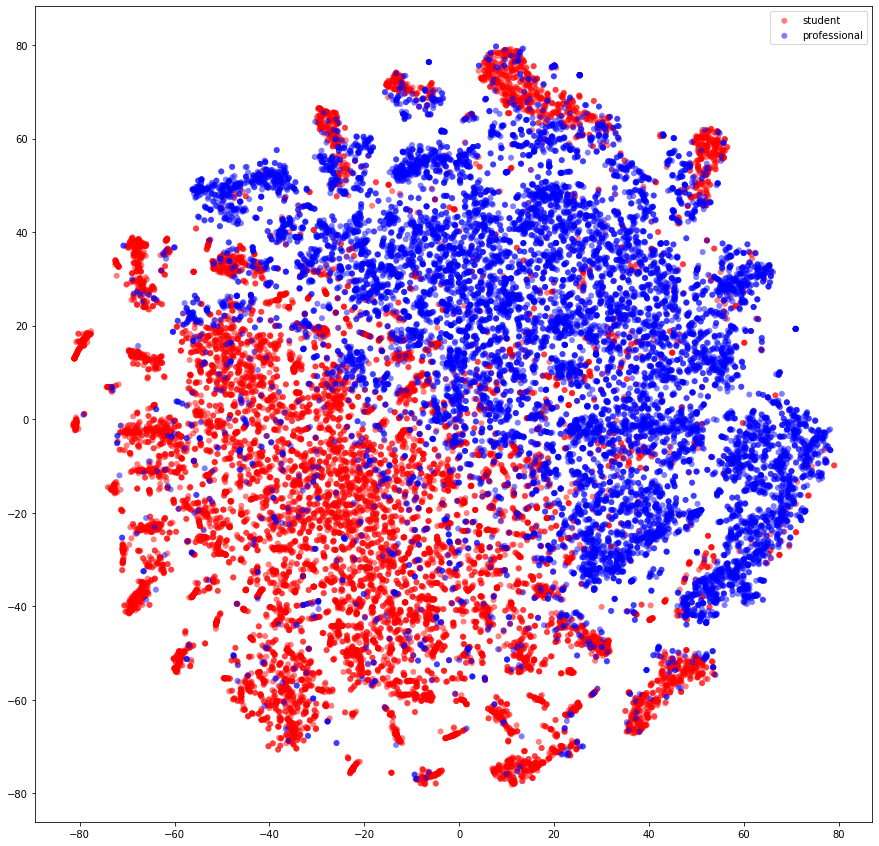

In [43]:
visu_embeddings(usr_tsne_emb, usr_tsne_lab)

In [64]:
import pandas as pd
y_data=pd.Series(y_data)
y_data=y_data.map(lambda x:0 if x=='student' else 1)

# 6. まとめ

キャリアビレッジのデータには、いくつかのエンティティが含まれており、それらの間には異なるタイプのコネクションが存在しています。私の最終的な目標は、このデータをネットワーク構造の側面からのみ分析することでした。

私は、基礎となるナレッジグラフのみを用いて、ユーザーを**学生**と**専門家**に分けることに成功しました。まず，**node2vec**を用いてネットワークのノードを10次元ユークリッド空間にマッピングした．次に、t-SNEによる次元削減を行い、結果を可視化した。

**このトピックやノートブックに関する質問があれば、[私](https://github.com/ferencberes)までお気軽にお問い合わせください。:)**

In [65]:
# from sklearn.ensemble import RandomForestClassifier
# model=RandomForestClassifier()
# model.fit(usr_tsne_emb, usr_tsne_lab)

/Users/ogata2/.pyenv/versions/3.7.5/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c

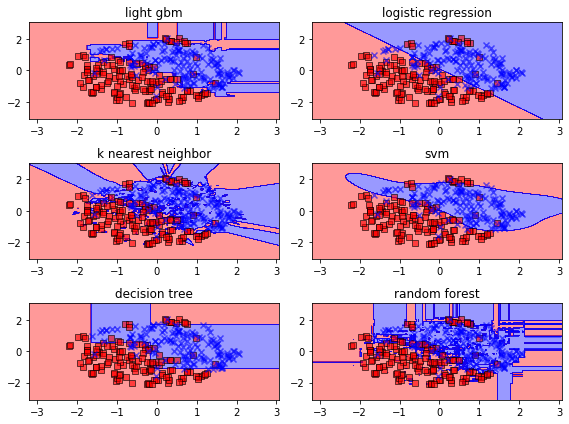

In [71]:
import numpy as np
from sklearn import datasets
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import math


#
# 決定境界プロット関数
#
def plot_decision_regions(x, y, model, resolution=0.01):

    ## 今回は被説明変数が3クラスのため散布図のマーカータイプと3種類の色を用意
    ## クラスの種類数に応じて拡張していくのが良いでしょう
    markers = ('s', 'x', )
    cmap = ListedColormap(('red', 'blue',))

    ## 2変数の入力データの最小値から最大値まで引数resolutionの幅でメッシュを描く
    x1_min, x1_max = x[:, 0].min()-1, x[:, 0].max()+1
    x2_min, x2_max = x[:, 1].min()-1, x[:, 1].max()+1
    x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                                   np.arange(x2_min, x2_max, resolution))

    ## メッシュデータ全部を学習モデルで分類
    z = model.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
    z = z.reshape(x1_mesh.shape)

    ## メッシュデータと分離クラスを使って決定境界を描いている
    plt.contourf(x1_mesh, x2_mesh, z, alpha=0.4, cmap=cmap)
    plt.xlim(x1_mesh.min(), x1_mesh.max())
    plt.ylim(x2_mesh.min(), x2_mesh.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=x[y == cl, 0],
                    y=x[y == cl, 1],
                    alpha=0.6,
                    c=cmap(idx),
                    edgecolors='black',
                    marker=markers[idx],
                    label=cl)

#
# データの取得
#
# data = datasets.load_iris()
# x_data,y_data =usr_tsne_emb, usr_tsne_lab

# 2変数だけを抽出
x_data = x_data[:, [0,1]]

# 入力データの各変数が平均0,標準偏差1になるように正規化
# 各アルゴリズムのプロット結果を比較しやすいように予め全入力データを正規化
sc = StandardScaler()
sc.fit(x_data)
x_data = sc.transform(x_data)


# データを学習用/テスト用に分割している
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size=0.01)

#
# 機械学習アルゴリズムの定義
#
lb=lgb.LGBMClassifier()
lr = LogisticRegression(C=10)
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel='rbf', C=1.0)
dc = DecisionTreeClassifier(criterion='entropy', max_depth=3)
rf = RandomForestClassifier(criterion='entropy',
                            n_estimators=10)

models = [lb,lr, knn, svm, dc, rf]
model_names = ["light gbm",'logistic regression',
               'k nearest neighbor',
               'svm',
               'decision tree',
               'random forest']

#
# それぞれのモデルにおいて決定境界をプロット
#
plt.figure(figsize=(8,6))
plot_num = 1
for model_name, model in zip(model_names, models):

    plt.subplot(math.ceil(len(models)/2), 2, plot_num)
    # モデルの学習
    model.fit(x_train, y_train)
    # 決定境界をプロット
    plot_decision_regions(x_test, y_test, model)
    plt.title(model_name)
    plot_num += 1

plt.tight_layout()
# plt.savefig('./images/decision_region.png')
plt.show()